# 전이학습

In [1]:
# @title gdown
import gdown, zipfile, os

file_id = '1HuzYaEgKCvHFkMU5iQMM4oKfGl3OP3rf'

gdown.download(f'https://drive.google.com/uc?id={file_id}', 'SUV_kor.zip', quiet=False)

dir = 'SUV-classification2'
os.makedirs(dir, exist_ok=True)  # 없으면 생성

with zipfile.ZipFile('SUV_kor.zip', 'r') as z:
    z.extractall(dir)

Downloading...
From (original): https://drive.google.com/uc?id=1HuzYaEgKCvHFkMU5iQMM4oKfGl3OP3rf
From (redirected): https://drive.google.com/uc?id=1HuzYaEgKCvHFkMU5iQMM4oKfGl3OP3rf&confirm=t&uuid=d0892fbd-02ae-42d0-9492-8b6b1e51b2fc
To: /content/SUV_kor.zip
100%|██████████| 1.75G/1.75G [00:23<00:00, 75.8MB/s]


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split

def sample(x):

  return x.sample(1000)

def load_data(base_dir='SUV-classification2'):
  images = []
  labels = []

  sampled_images = []
  sampled_labels = []


  base = os.path.join(base_dir, 'SUV')

  for category in [ 'Hyundai', 'Kia', ]:
    category_path = os.path.join(base, category) # vehicle-classification/pics/BMW

    for filename in os.listdir(category_path):
      if '.jpg' in filename:
        file_path = os.path.join(category_path, filename)
        images.append(file_path)
        texts = filename.replace('_','$').replace('-','$')
        texts = texts.split('$')
        labels.append(texts[1])


  df_temp = pd.DataFrame({
    'path': images,
    'label': labels
  })

  return df_temp


In [3]:
#@title 10개 차종 천장씩 분류
df_temp = load_data()

data_set = pd.DataFrame()

for g in df_temp['label'].unique():
  if(len(df_temp[df_temp['label'] == g].value_counts())>1000):
    temp_df = df_temp[df_temp['label'] == g].sample(1000)
    data_set = pd.concat([data_set, temp_df])


print(data_set['label'].value_counts())
print(data_set.head())

# # 데이터 로드 및 분리
# (tr_images, tr_labels), (test_images, test_labels) = load_data()

# # 입력 데이터 전처리
# test_images = test_images.reshape(-1, 28, 28, 1) / 255.0  # 크기 및 정규화
# test_labels = test_labels  # 레이블은 그대로 사용

# 훈련/test 셋 분할

# 데이터셋에서 이미지 경로와 레이블 추출
image_paths = data_set['path'].tolist()  # 경로
labels = data_set['label'].tolist()  # 레이블

# 데이터셋 분리
tr_image_paths, test_image_paths, tr_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42)

#tr_image_paths.shape, tr_labels.shape, test_image_paths.shape, test_labels.shape  #images path


label
Tucson      1000
Santafe     1000
Palisade    1000
Veracruz    1000
Kona        1000
Seltos      1000
Carens      1000
Sorento     1000
Sportage    1000
Mohave      1000
Soul        1000
Niro        1000
Name: count, dtype: int64
                                                    path   label
23335  SUV-classification2/SUV/Hyundai/SUV_Tucson-121...  Tucson
2376   SUV-classification2/SUV/Hyundai/SUV_Tucson-496...  Tucson
7486   SUV-classification2/SUV/Hyundai/SUV_Tucson-240...  Tucson
31627  SUV-classification2/SUV/Hyundai/SUV_Tucson-516...  Tucson
1247   SUV-classification2/SUV/Hyundai/SUV_Tucson-204...  Tucson


##  Xception 모델 로드

In [4]:
#Xception은 299*299 사이즈로 전달해줘야 함
from tensorflow.keras.applications import ResNet50V2

pretrained_model = ResNet50V2(
    weights='imagenet',
    input_shape=(224, 224, 3),
    include_top=True
)

# 모델 구조 출력
pretrained_model.summary()

102869336/102869336 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "resnet50v2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_conv[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_bn    │ (None, 56, 56, 64)     │            256 │ pool1_pool[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_relu  │ (None, 56, 56, 64)     │              0 │ conv2_block1_preact_b… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,096 │ conv2_block1_preact_r… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_pad        │ (None, 58, 58, 64)     │              0 │ conv2_block1_1_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,864 │ conv2_block1_2_pad[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_preact_r… │
│ (Conv2D)             

 Total params: 25,613,800 (97.71 MB)

 Trainable params: 25,568,360 (97.54 MB)

 Non-trainable params: 45,440 (177.50 KB)

## 이미지 전처리

In [5]:
# 경로 및 레이블 점검
print(f"Training image paths: {tr_image_paths[:5]}")
print(f"Test image paths: {test_image_paths[:5]}")

Training image paths: ['SUV-classification2/SUV/Kia/SUV_Mohave-107.jpg', 'SUV-classification2/SUV/Kia/SUV_Niro-754.jpg', 'SUV-classification2/SUV/Kia/SUV_Carens-490.jpg', 'SUV-classification2/SUV/Hyundai/SUV_Tucson-8285.jpg', 'SUV-classification2/SUV/Hyundai/SUV_Palisade-2348.jpg']
Test image paths: ['SUV-classification2/SUV/Hyundai/SUV_Santafe-7170.jpg', 'SUV-classification2/SUV/Kia/SUV_Carens-1369.jpg', 'SUV-classification2/SUV/Hyundai/SUV_Santafe-4746.jpg', 'SUV-classification2/SUV/Kia/SUV_Mohave-1165.jpg', 'SUV-classification2/SUV/Hyundai/SUV_Tucson-7917.jpg']


In [6]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelEncoder
import numpy as np
IMAGE_SIZE=150
def preprocess_image(image_path, image_size):
    image = load_img(image_path, target_size=(image_size, image_size))  # 경로에서 이미지를 로드
    image = img_to_array(image)  # 이미지를 배열로 변환
    image = image / 255.0  # 정규화
    return image


# 이미지 전처리
IMAGE_SIZE = 299  # Xception의 입력 크기
tr_images = np.array([preprocess_image(path, IMAGE_SIZE) for path in tr_image_paths])
test_images = np.array([preprocess_image(path, IMAGE_SIZE) for path in test_image_paths])
# 레이블 인코딩
label_encoder = LabelEncoder()
tr_labels = label_encoder.fit_transform(tr_labels)
test_labels = label_encoder.transform(test_labels)


In [8]:
#weights 수정 /
'''
weights=None
설명:
weights=None으로 설정하면 모델의 가중치가 무작위로 초기화됩니다.
모델이 처음부터 새 데이터에 대해 학습하도록 하려는 경우에 사용됩니다.
사용 시점:
데이터셋이 ImageNet 데이터와 완전히 다른 도메인(예: 의료 영상, 위성 이미지 등)일 때.
전이 학습이 불가능하거나 기존 가중치가 도움이 되지 않는다고 판단되는 경우.
모델을 처음부터 끝까지 새로 훈련시키고 싶을 때
'''
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import applications
base_model = applications.ResNet50(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    include_top=False,
    weights='imagenet'
)
#모델의 실행 결과를 인풋으로 불러온다.
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(500, activation='relu', kernel_initializer='he_normal')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu',kernel_initializer='he_normal')(x)
x = layers.Dense(512, activation='relu',kernel_initializer='he_normal')(x)
x = layers.Dropout(0.3)(x)
output = layers.Dense(12, activation='softmax')(x)
model = models.Model(base_model.input, output)
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 299, 299, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 305, 305, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 150, 150, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 150, 150, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 150, 150, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 152, 152, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 75, 75, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 75, 75, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 75, 75, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 75, 75, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 75, 75, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 75, 75, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 75, 75, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 75, 75, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 75, 75, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 24,878,208 (94.90 MB)

 Trainable params: 24,825,088 (94.70 MB)

 Non-trainable params: 53,120 (207.50 KB)

## 모델 컴파일 부터 시각화까지

In [9]:
#@title 점검
print(f"tr_images: {type(tr_images)}, shape: {getattr(tr_images, 'shape', 'None')}")
print(f"tr_labels: {type(tr_labels)}, length: {len(tr_labels) if tr_labels is not None else 'None'}")
print(f"test_images: {type(test_images)}, shape: {getattr(test_images, 'shape', 'None')}")
print(f"test_labels: {type(test_labels)}, length: {len(test_labels) if test_labels is not None else 'None'}")
print("Model Input Shape:", model.input_shape)

tr_images: <class 'numpy.ndarray'>, shape: (9600, 299, 299, 3)
tr_labels: <class 'numpy.ndarray'>, length: 9600
test_images: <class 'numpy.ndarray'>, shape: (2400, 299, 299, 3)
test_labels: <class 'numpy.ndarray'>, length: 2400
Model Input Shape: (None, 299, 299, 3)


Epoch 1/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 102s 129ms/step - accuracy: 0.2235 - loss: 2.2961 - val_accuracy: 0.0833 - val_loss: 2.6777 - learning_rate: 0.0010
Epoch 2/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 27s 88ms/step - accuracy: 0.6348 - loss: 1.0561 - val_accuracy: 0.1617 - val_loss: 4.3550 - learning_rate: 0.0010
Epoch 3/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 27s 88ms/step - accuracy: 0.7828 - loss: 0.6753 - val_accuracy: 0.7525 - val_loss: 0.7679 - learning_rate: 0.0010
Epoch 4/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 27s 89ms/step - accuracy: 0.8849 - loss: 0.3886 - val_accuracy: 0.8512 - val_loss: 0.4971 - learning_rate: 0.0010
Epoch 5/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 27s 89ms/step - accuracy: 0.9051 - loss: 0.3362 - val_accuracy: 0.8246 - val_loss: 0.9498 - learning_rate: 0.0010
Epoch 6/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 27s 89ms/step - accuracy: 0.9169 - loss: 0.2818 - val_accuracy: 0.8554 - val_loss: 0.5663 - learning_rate: 0.0010
Epoch 7/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 27s 89ms/step - accuracy: 0.9201 -

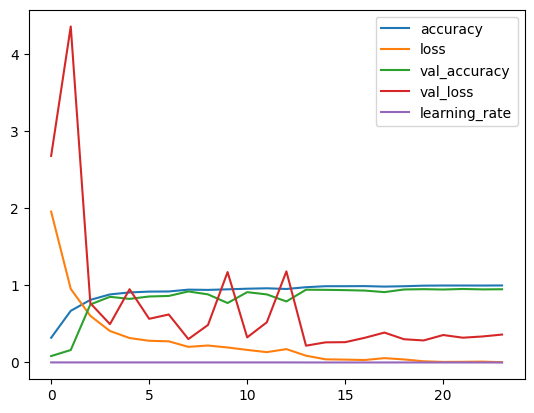

In [10]:
#모델 컴파일
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
BATCH_SIZE = 32
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

early_stopping_cb = EarlyStopping(patience=10, verbose=1, restore_best_weights=True)
reduce_lr_on_plateau_cb = ReduceLROnPlateau(patience=5, factor=0.5, verbose=1)

# 모델 학습
history = model.fit(
    tr_images, tr_labels,
    validation_data=(test_images, test_labels),
    epochs=50,
    batch_size=32,  # 배치 크기 설정
    callbacks=[early_stopping_cb, reduce_lr_on_plateau_cb]
)

#학습결과 시각화
hist_df = pd.DataFrame(history.history).plot()
plt.show()


## 결과

In [11]:
#@title 학습결과 지표 엑셀화
hist_df = pd.DataFrame(history.history)

# DataFrame을 Excel 파일로 저장
hist_df.to_excel('training_history.xlsx', index=False)

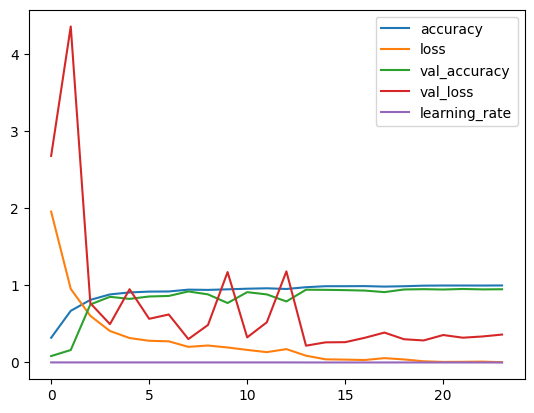

75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.9414 - loss: 0.2169
Test Loss: 0.217915877699852
Test Accuracy: 0.9433333277702332


In [12]:
#@title 학습결과 종합지표 시각화
import pandas as pd
hist_df = pd.DataFrame(history.history).plot()
plt.show()

# 평가
loss, accuracy = model.evaluate(test_images, test_labels)

# 평가 결과 출력
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

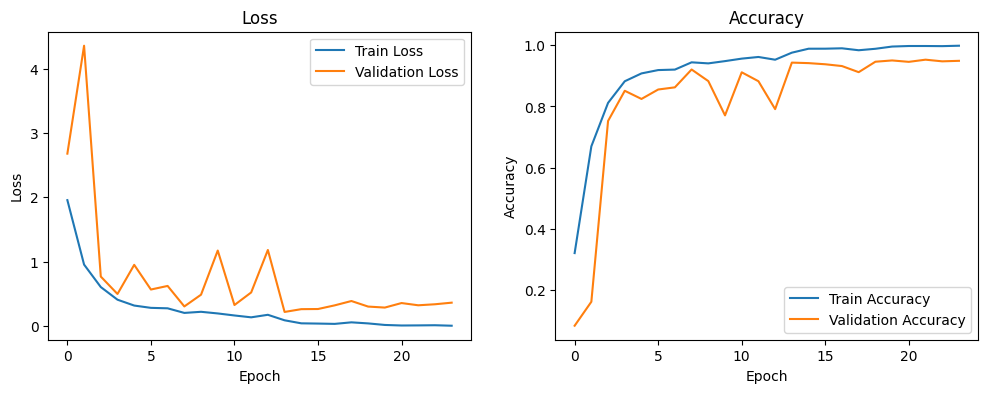

In [13]:
#@title  학습결과 시각화 - 손실 / 정확도
# 훈련 과정 시각화
plt.figure(figsize=(12, 4))

# 손실값 시각화
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 정확도 시각화
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 시각화된 그래프를 이미지 파일로 저장
plt.savefig('training_results.png')
plt.show()

In [15]:
#@title 모델 저장
model.save("ResNet_model.keras")